### To Do

> today
1. for probeA, average and plot LFP for each channel -> to understand polarity
2. repeat for each probe
3. find a depth that produces the same polarity among all the probes
4. try PSD (maybe)
5. Repeat analysis and HMM to double check on the omitted trials (compared to gray screens)
> just for fun lol
1. Try to find recurring patterns/sequences

### Libraries and dependencies

In [1]:
import gc
import umap
import numpy as np
import pandas as pd
from hmmlearn import hmm
from tqdm import tqdm
from copy import deepcopy
from scipy.stats import zscore, mode, entropy, sem
from matplotlib import pyplot as plt
from scipy.signal import butter, sosfiltfilt, hilbert, decimate, stft
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
output_dir = "E:/jerry/vbn_s3_cache"
#output_dir = "C:/users/jerry/downloads/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

e:\jerry\anaconda\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Day 1

In [2]:
"""# mouse id: 533537
session = cache.get_ecephys_session(ecephys_session_id=1055221968) # type: ignore
probeA = session.get_lfp(1055328904) #VISam
probeB = session.get_lfp(1055328905) #VISpm
probeC = session.get_lfp(1055328906) #VISp
probeD = session.get_lfp(1055328908) #VISl
probeE = session.get_lfp(1055328909) #VISal
probeF = session.get_lfp(1055328910) #VISrl

# mouse id: 533539
session = cache.get_ecephys_session(ecephys_session_id=1055240613) # type: ignore
probeA = session.get_lfp(1055324727) #VISam
probeB = session.get_lfp(1055324728) #VISpm
probeC = session.get_lfp(1055324729) #VISp
probeD = session.get_lfp(1055324730) #VISl
probeE = session.get_lfp(1055324731) #VISal
probeF = session.get_lfp(1055324732) #VISrl""";

# mouse id: 541234
session = cache.get_ecephys_session(ecephys_session_id=1062755779) # type: ignore
probeA = session.get_lfp(1062886496) #VISam
probeB = session.get_lfp(1062886497) #VISpm
probeC = session.get_lfp(1062886498) #VISp
probeD = session.get_lfp(1062886499) #VISl
probeE = session.get_lfp(1062886500) #VISal
probeF = session.get_lfp(1062886501) #VISrl

### Day2

In [ ]:
# mouse id: 533537
session = cache.get_ecephys_session(ecephys_session_id=1055403683) # type: ignore
probeA = session.get_lfp(1055529304) #VISam
probeB = session.get_lfp(1055529306) #VISpm
probeC = session.get_lfp(1055529307) #VISp
probeD = session.get_lfp(1055529308) #VISl
probeE = session.get_lfp(1055529309) #VISal
probeF = session.get_lfp(1055529310) #VISrl

### Stims

In [122]:
# getting the start and end of stim block 0
sp = session.stimulus_presentations
sp = sp[sp['stimulus_block'] == 0]
start = sp.start_time.values
end = sp.end_time.values
# 1000ms buffer in both ends, 250ms before start, 1250Hz sampling rate
imgs = np.unique(sp['image_name'].values)
omitted = sp[sp['omitted']==True]
miss = sp[(sp['is_change']==True) & (sp['rewarded']==False)]
hit = sp[(sp['is_change']==True) & (sp['rewarded']==True)]

Day 1: ['im012_r', 'im036_r', 'im044_r', 'im047_r', 'im078_r', 'im083_r', 'im111_r', 'im115_r', 'omitted']
<br>
Day 2: ['im005_r', 'im024_r', 'im034_r', 'im083_r', 'im087_r', 'im104_r', 'im111_r', 'im114_r', 'omitted']

### Slicing LFP

In [123]:
def nearest_sg(array, value):
    return np.argmin(np.abs(array - value))

def nearest_arr(array, target):
    results = np.zeros(len(target), dtype='int')
    for i, t in enumerate(target):
        results[i] = nearest_sg(array, t)
    return results

In [124]:
master_time = np.arange(start[0]-1, end[-1]+1, 1/1250)
chan = session.get_channels()
probes = [probeA, probeB, probeC, probeD, probeE, probeF]

In [125]:
for i in probes:
    print(np.unique(chan.loc[i.channel].structure_acronym.values))

['APN' 'CA1' 'DG' 'MB' 'NOT' 'VISam' 'root']
['APN' 'CA1' 'DG' 'MB' 'VISpm' 'root']
['APr' 'MB' 'MRN' 'POST' 'RN' 'RSPd' 'SCig' 'SCiw' 'VISp' 'root']
['CA1' 'CA3' 'DG' 'MGm' 'MGv' 'PIL' 'VISl' 'root']
['CA1' 'CA3' 'DG' 'MGd' 'MGm' 'MGv' 'PoT' 'TH' 'VISal' 'root']
['CA1' 'CA3' 'DG' 'LGd' 'LP' 'POL' 'PoT' 'SGN' 'VISrl' 'root']


In [126]:
vis_names = ['VISam', 'VISpm', 'VISp', 'VISl', 'VISal', 'VISrl']
lfp = np.zeros((len(vis_names), len(master_time)))

2720
3040
3160
2720
3120
2920

2720
3040
3120
2680
3120
2880

In [147]:
for i in range(len(probes)):
    probe = probes[i]
    probe_chans = chan.loc[probe.channel]
    probe_chans = probe_chans[probe_chans['structure_acronym']==vis_names[i]]
    print(probe_chans.probe_vertical_position)
    ids = probe_chans.index
    id_idx = int(np.ceil(len(ids)*0.7))
    id_select = ids[id_idx]
    print(id_select, probe_chans.probe_vertical_position.values[id_idx])
    probe_chan = probe.sel(channel=id_select)
    probe_chan_sel = probe_chan.sel(time=master_time, method='nearest')
    lfp[i] = probe_chan_sel
    display(probe_chans.loc[id_select])

id
1066258128    2240
1066258132    2280
1066258137    2320
1066258141    2360
1066258145    2400
1066258149    2440
1066258153    2480
1066258157    2520
1066258161    2560
1066258165    2600
1066258169    2640
1066258173    2680
1066258177    2720
1066258181    2760
1066258185    2800
1066258189    2840
1066258193    2880
1066258197    2920
Name: probe_vertical_position, dtype: int64
1066258181 2760


anterior_posterior_ccf_coordinate                                               7511.0
dorsal_ventral_ccf_coordinate                                                    518.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       7321.0
probe_channel_number                                                               274
probe_horizontal_position                                                           59
probe_id                                                                    1062886496
probe_vertical_position                                                           2760
structure_acronym                                                                VISam
Name: 1066258181, dtype: object

id
1066258540    2400
1066258544    2440
1066258548    2480
1066258552    2520
1066258556    2560
1066258560    2600
1066258564    2640
1066258568    2680
1066258572    2720
1066258576    2760
1066258581    2800
1066258585    2840
1066258589    2880
1066258593    2920
1066258597    2960
1066258601    3000
1066258605    3040
1066258609    3080
1066258613    3120
1066258617    3160
1066258621    3200
1066258625    3240
Name: probe_vertical_position, dtype: int64
1066258605 3040


anterior_posterior_ccf_coordinate                                               7770.0
dorsal_ventral_ccf_coordinate                                                    472.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       7263.0
probe_channel_number                                                               302
probe_horizontal_position                                                           59
probe_id                                                                    1062886497
probe_vertical_position                                                           3040
structure_acronym                                                                VISpm
Name: 1066258605, dtype: object

id
1066258972    2760
1066258976    2800
1066258980    2840
1066258984    2880
1066258988    2920
1066258992    2960
1066258996    3000
1066259000    3040
1066259004    3080
1066259008    3120
1066259012    3160
1066259016    3200
1066259021    3240
1066259025    3280
1066259029    3320
Name: probe_vertical_position, dtype: int64
1066259016 3200


anterior_posterior_ccf_coordinate                                               9551.0
dorsal_ventral_ccf_coordinate                                                    740.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       7555.0
probe_channel_number                                                               318
probe_horizontal_position                                                           59
probe_id                                                                    1062886498
probe_vertical_position                                                           3200
structure_acronym                                                                 VISp
Name: 1066259016, dtype: object

id
1066259342    2520
1066259346    2560
1066259350    2600
1066259354    2640
1066259358    2680
1066259362    2720
1066259366    2760
1066259370    2800
1066259374    2840
1066259378    2880
1066259383    2920
1066259388    2960
1066259392    3000
1066259396    3040
Name: probe_vertical_position, dtype: int64
1066259383 2920


anterior_posterior_ccf_coordinate                                               9038.0
dorsal_ventral_ccf_coordinate                                                   1905.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       9651.0
probe_channel_number                                                               290
probe_horizontal_position                                                           59
probe_id                                                                    1062886499
probe_vertical_position                                                           2920
structure_acronym                                                                 VISl
Name: 1066259383, dtype: object

id
1066259729    2440
1066259733    2480
1066259738    2520
1066259742    2560
1066259746    2600
1066259750    2640
1066259754    2680
1066259758    2720
1066259762    2760
1066259766    2800
1066259770    2840
1066259774    2880
1066259778    2920
1066259782    2960
1066259786    3000
1066259790    3040
1066259794    3080
1066259798    3120
1066259802    3160
1066259806    3200
Name: probe_vertical_position, dtype: int64
1066259786 3000


anterior_posterior_ccf_coordinate                                               7988.0
dorsal_ventral_ccf_coordinate                                                   1830.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       9857.0
probe_channel_number                                                               298
probe_horizontal_position                                                           59
probe_id                                                                    1062886500
probe_vertical_position                                                           3000
structure_acronym                                                                VISal
Name: 1066259786, dtype: object

id
1066260121    2400
1066260125    2440
1066260129    2480
1066260133    2520
1066260137    2560
1066260141    2600
1066260146    2640
1066260150    2680
1066260154    2720
1066260158    2760
1066260162    2800
1066260166    2840
1066260170    2880
1066260174    2920
1066260178    2960
1066260182    3000
1066260186    3040
1066260190    3080
1066260194    3120
1066260198    3160
Name: probe_vertical_position, dtype: int64
1066260178 2960


anterior_posterior_ccf_coordinate                                               7384.0
dorsal_ventral_ccf_coordinate                                                   1176.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       8990.0
probe_channel_number                                                               294
probe_horizontal_position                                                           59
probe_id                                                                    1062886501
probe_vertical_position                                                           2960
structure_acronym                                                                VISrl
Name: 1066260178, dtype: object

In [148]:
lfp_stim = np.zeros((6, 2000, 2100))
for i in tqdm(range(2000)):
    start_idx = nearest_sg(master_time, start[i*2]-0.25)
    end_idx = nearest_sg(master_time, end[i*2+1]+0.5)
    for j in range(6):
        lfp_stim[j][i] = lfp[j][start_idx:end_idx][:2100]

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [01:38<00:00, 20.34it/s]


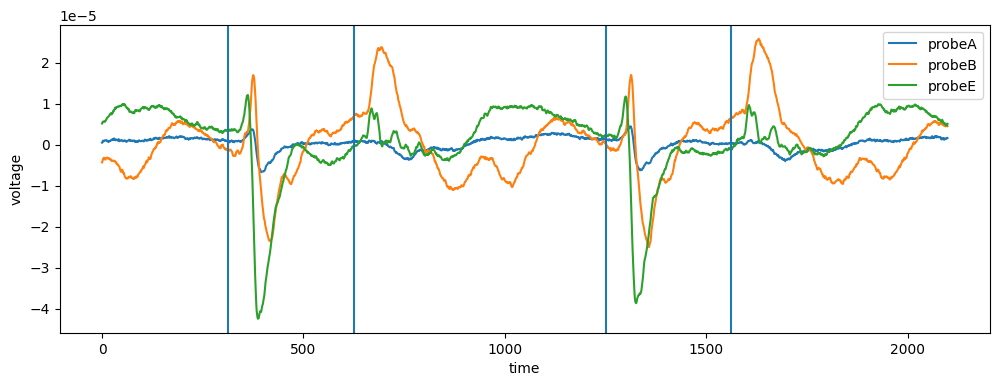

In [146]:
plt.figure(figsize=(12, 4))
plt.plot(np.mean(lfp_stim[0], axis=0), label='probeA')
plt.plot(np.mean(lfp_stim[1], axis=0), label='probeB')
plt.plot(np.mean(lfp_stim[2], axis=0), label='probeC')
plt.plot(np.mean(lfp_stim[3], axis=0), label='probeD')
plt.plot(np.mean(lfp_stim[4], axis=0), label='probeE')
plt.plot(np.mean(lfp_stim[5], axis=0), label='probeF')

plt.axvline(int(250/0.8))
plt.axvline(int(500/0.8))
plt.axvline(int(1000/0.8))
plt.axvline(int(1250/0.8))
"""plt.axvline(int(1750/0.8))
plt.axvline(int(2000/0.8))
plt.axvline(int(2500/0.8))
plt.axvline(int(2750/0.8))
"""

plt.xlabel('time')
plt.ylabel('voltage')
plt.legend()

### GaussianHMM

#### LL and elbow test

In [ ]:
ns = np.arange(2,21)
lls = np.zeros(len(ns))
for i, n in tqdm(enumerate(ns)):
    ll_temp = 0
    for iter in range(3):
        model = hmm.GaussianHMM(n_components=n, n_iter=1000, verbose=False, tol=0.1)
        model.fit(bands_z)
        ll_temp+=model.score(bands_z)
    lls[i] = ll_temp/3

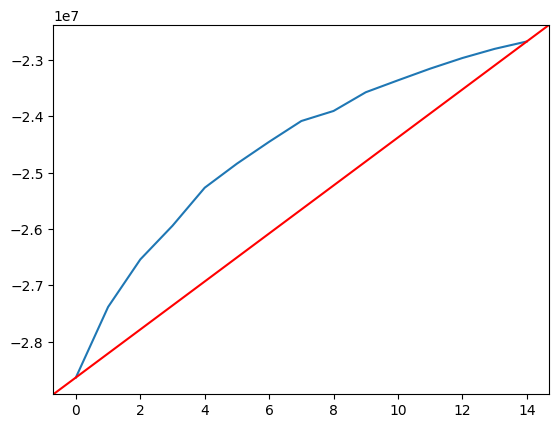

In [373]:
plt.plot(np.arange(len(lls)-4), lls[:-4])
plt.axline((0, lls[0]), (len(lls)-5, lls[-5]), c='r')

In [378]:
lls_new = lls[:-4]
slope = (lls_new[-1]-lls_new[0])/(len(lls_new)-1)
intercept = lls_new[0]


In [376]:
def d(slope, intercept, x1, y1):
    return np.abs(slope*x1-y1+intercept)/np.sqrt(slope**2+1)

In [381]:
ds = np.zeros(len(lls_new))
for i in range(len(lls_new)):
    ds[i]=d(slope, intercept, i, lls_new[i])

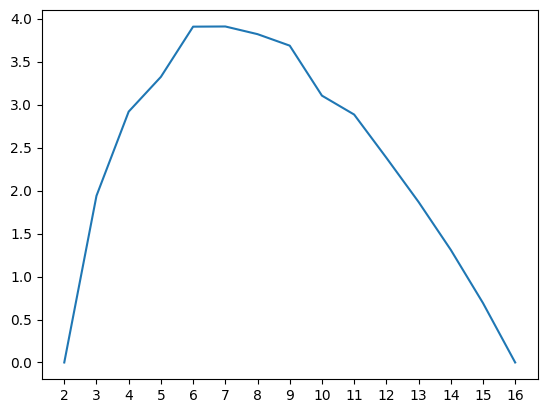

In [386]:
plt.plot(np.arange(len(ds)), ds)
plt.xticks(ticks=np.arange(len(ds)), labels=np.arange(len(ds))+2);

In [437]:
ds_penal = np.zeros(len(lls_new))
for i in range(len(lls_new)):
    ds_penal[i]=d(slope, intercept, i, lls_new[i])/(i+2)

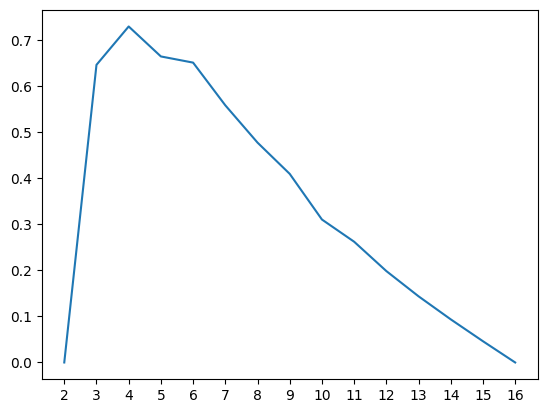

In [438]:
plt.plot(np.arange(len(ds_penal)), ds_penal)
plt.xticks(ticks=np.arange(len(ds_penal)), labels=np.arange(len(ds_penal))+2);

#### Filtering LFP

In [9]:
bands = np.zeros((4, 6, lfp.shape[1])) # 4 bands, 6 channels, 4.5M samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in tqdm(enumerate(Wns)): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, lfp) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env) # type: ignore
    bands[i] = all_channels_env_abs
bands = bands[:,:,1250:-1250]
b = np.reshape(bands, (4*6, -1))
b_z = zscore(b, axis=1)
b_z_0 = zscore(b, axis=0)
bands.shape,b_z.shape

4it [00:36,  9.01s/it]


((4, 6, 4500222), (24, 4500222))

In [150]:
# plotting state
def plot(preds, num=3, time_bin=0.8):
    preds_no_buffer = preds[int(250/time_bin):] # remove buffer
    plt.plot(preds_no_buffer[0:int(750*num/time_bin)])
    start_time = 0
    for i in range(num):
        plt.axvspan(start_time/time_bin, (start_time+250)/time_bin, alpha=0.2, color='red') # stimulus
        start_time += 250
        plt.axvspan(start_time/time_bin, (start_time+500)/time_bin, alpha=0.2, color='gray') # gray
        start_time += 500

#### 4 hidden states

In [10]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=1)
model.fit(b_z.T)
preds = model.predict(b_z.T)

         1 -154249359.47561473             +nan
         2 -143006067.17496732 +11243292.30064741
         3 -141478151.31498501 +1527915.85998231
         4 -141220306.50751090 +257844.80747411
         5 -141143543.84532639  +76762.66218451
         6 -141100095.05110234  +43448.79422405
         7 -141074499.85513172  +25595.19597062
         8 -141058512.19461283  +15987.66051888
         9 -141048155.63299510  +10356.56161773
        10 -141041569.30728474   +6586.32571036
        11 -141037487.23458764   +4082.07269710
        12 -141034973.17600110   +2514.05858654
        13 -141033433.72245273   +1539.45354837
        14 -141032510.47775203    +923.24470070
        15 -141031940.14295885    +570.33479318
        16 -141031573.60421684    +366.53874201
        17 -141031333.95246542    +239.65175143
        18 -141031176.17847264    +157.77399278
        19 -141031071.29167318    +104.88679945
        20 -141030999.43242186     +71.85925132
        21 -141030948.24046618     +5

0it [00:00, ?it/s]

3it [00:25,  8.59s/it]


Text(0.02, 0.5, 'Percentage')

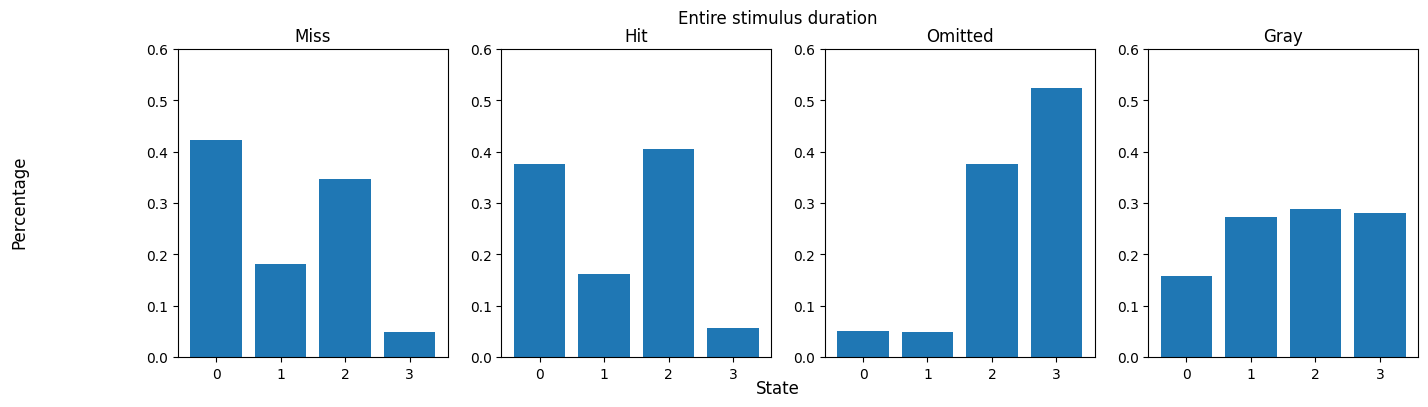

In [14]:
m_t = master_time[1250:-1250]
gray_mask = np.ones(len(m_t))
distribution=np.zeros((4, 4))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values

    stim_start_idx = nearest_arr(m_t, stim_start)
    stim_end_idx = nearest_arr(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        gray_mask[idx:stim_end_idx[i]] = 0
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
for idx, i in enumerate(gray_mask):
    if i == 1:
        distribution[-1][preds[idx]] += 1

d = deepcopy(distribution)
for i in range(4):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 4,figsize=(16,4))
axs[0].bar(np.arange(4), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.61,0.1))
axs[1].bar(np.arange(4), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.61,0.1));
axs[2].bar(np.arange(4), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.61,0.1));
axs[3].bar(np.arange(4), d[3])
axs[3].set_title('Gray')
axs[3].set_yticks(np.arange(0,0.61,0.1));
fig.suptitle("Entire stimulus duration")
fig.supxlabel('State')
fig.supylabel('Percentage')

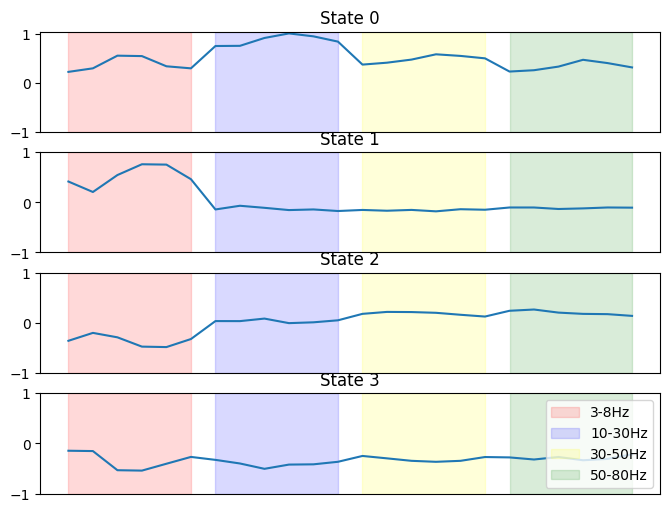

In [15]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

In [236]:
# caluclate the power associated with each state
b_z_temp = np.reshape(b_z, (4, 6, -1))
powers = np.mean(b_z_temp,axis=1)

In [249]:
state_0 = np.where(preds==0)[0]
state_1 = np.where(preds==1)[0]
state_2 = np.where(preds==2)[0]

In [255]:
state_0_power = powers[:,state_0].T
state_0_power[0]

array([-0.05480087, -0.37890785, -0.22110037, -0.0333835 ])

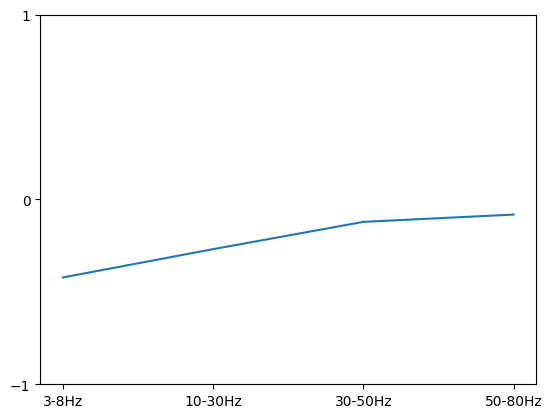

In [291]:
plt.plot(np.mean(state_0_power.T, axis=1));
plt.yticks(np.linspace(-1.,1.,3))
plt.xticks(ticks=np.arange(0,4), labels=['3-8Hz', '10-30Hz', '30-50Hz', '50-80Hz']);

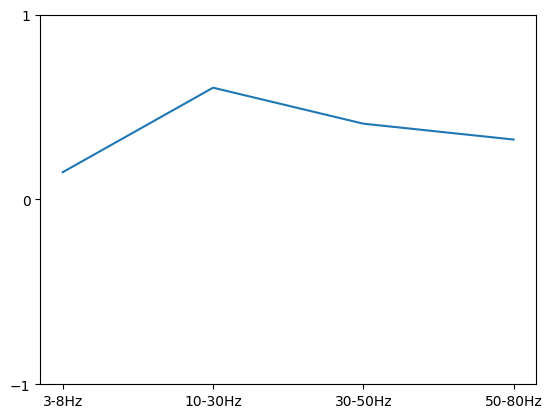

In [271]:
state_1_power = powers[:,state_1].T
plt.plot(np.mean(state_1_power.T, axis=1));
plt.yticks(np.linspace(-1.,1.,3))
plt.xticks(ticks=np.arange(0,4), labels=['3-8Hz', '10-30Hz', '30-50Hz', '50-80Hz']);

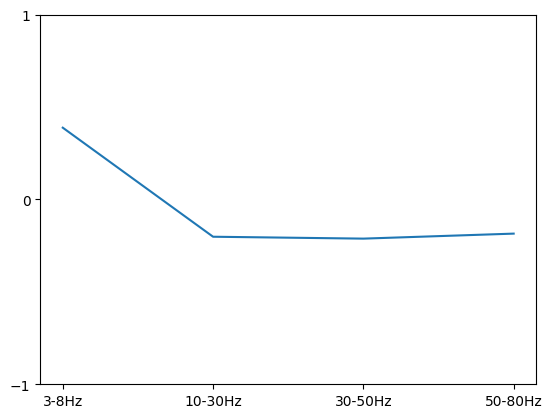

In [272]:
state_2_power = powers[:,state_2].T
state_2_power[0]
plt.plot(np.mean(state_2_power.T, axis=1));
plt.yticks(np.linspace(-1.,1.,3))
plt.xticks(ticks=np.arange(0,4), labels=['3-8Hz', '10-30Hz', '30-50Hz', '50-80Hz']);

0 938


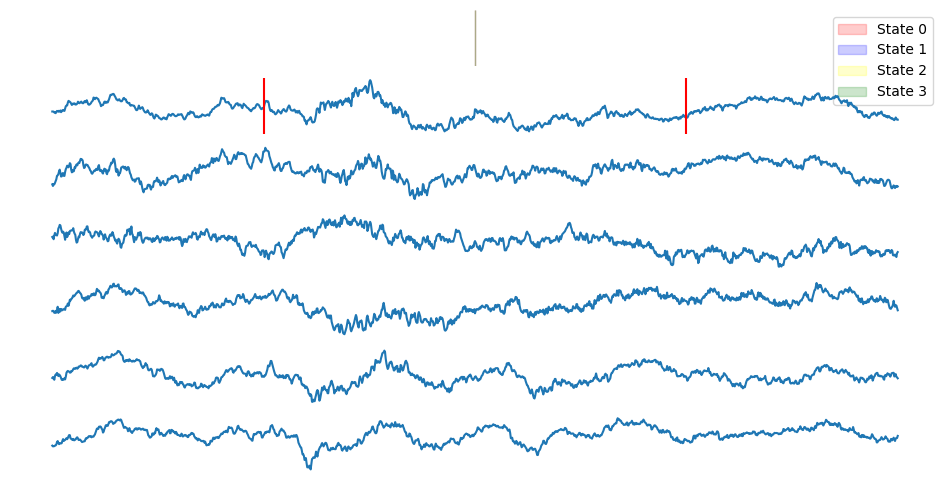

In [170]:
fig,axs=plt.subplots(7,1,figsize=(12,6))
# find a stimulus that contain all four states
for idx, i in enumerate(sp.index):
    s = sp.loc[i]
    s_start_idx = nearest_sg(m_t, s.start_time-0.25)
    s_end_idx = nearest_sg(m_t, s.end_time+0.5)
    print(s_start_idx, s_end_idx)
    unique, count = np.unique(preds[s_start_idx:s_end_idx], return_counts=True)
    if len(unique)==4:
        target = s
        break

# plot the lfp of the stimulus
start_t = target.start_time-0.25
start_i = nearest_sg(master_time, start_t)
end_t = target.end_time+0.5
end_i = nearest_sg(master_time, end_t)
state = preds[start_i-1250:end_i-1250]

colors = ['red', 'blue', 'yellow', 'green']
current_time = 0
for idx, i in enumerate(state):
    axs[0].axvspan(idx, idx+0.5, alpha=0.2, color=colors[i])


axs[1].plot(lfp[0][start_i:end_i])
axs[1].axvline(250/0.8, color='red')
axs[1].axvline(750/0.8, color='red')
axs[2].plot(lfp[1][start_i:end_i])
axs[3].plot(lfp[2][start_i:end_i])
axs[4].plot(lfp[3][start_i:end_i])
axs[5].plot(lfp[4][start_i:end_i])
axs[6].plot(lfp[5][start_i:end_i])

for i in range(0,7):
    axs[i].axis('off')
axs[0].axvspan(0,0,alpha=0.2, color='red', label='State 0')
axs[0].axvspan(0,0,alpha=0.2, color='blue', label='State 1')
axs[0].axvspan(0,0,alpha=0.2, color='yellow', label='State 2')
axs[0].axvspan(0,0,alpha=0.2, color='green', label='State 3')
axs[0].legend()

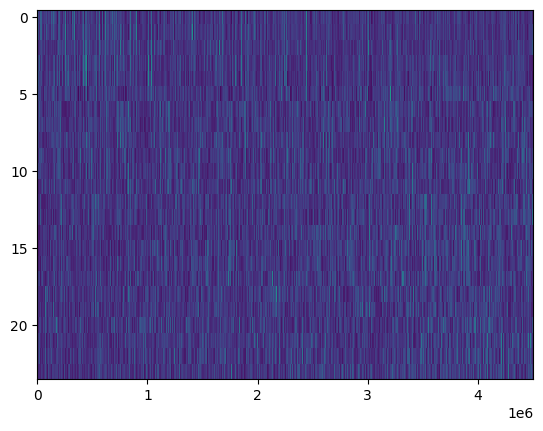

In [214]:
plt.imshow(b_z, aspect='auto', interpolation='none')

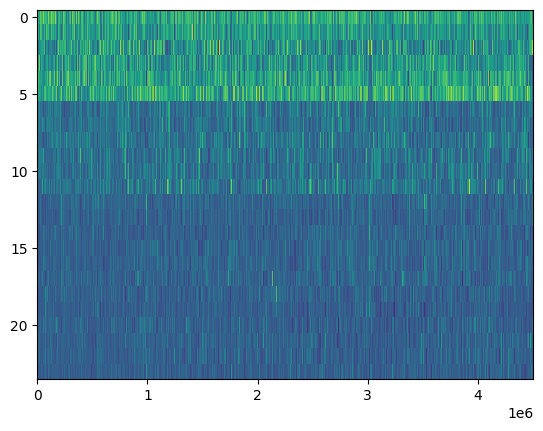

In [215]:
plt.imshow(b_z_0, aspect='auto', interpolation='none')

In [221]:
model = hmm.GaussianHMM(n_components=3, n_iter=1000, verbose=True, tol=0.1)
model.fit(b_z.T)
preds = model.predict(b_z.T)

         1 -151053439.67910537             +nan
         2 -144041946.58337703 +7011493.09572834
         3 -141626468.50392205 +2415478.07945499
         4 -141278148.47185308 +348320.03206897
         5 -141192455.06296664  +85693.40888643
         6 -141161859.93347254  +30595.12949410
         7 -141150491.82085821  +11368.11261433
         8 -141146290.93428579   +4200.88657242
         9 -141144701.17510960   +1589.75917619
        10 -141144114.96014413    +586.21496546
        11 -141143887.54336110    +227.41678303
        12 -141143794.73401490     +92.80934620
        13 -141143756.63223135     +38.10178354
        14 -141143741.03895453     +15.59327683
        15 -141143734.55480504      +6.48414949
        16 -141143731.72166997      +2.83313507
        17 -141143730.39732158      +1.32434839
        18 -141143729.73385102      +0.66347057
        19 -141143729.38025761      +0.35359341
        20 -141143729.17164195      +0.20861566
        21 -141143729.02735221      +0

In [222]:
model.transmat_

array([[0.98663117, 0.00220654, 0.01116229],
       [0.0032995 , 0.99378242, 0.00291807],
       [0.00834188, 0.00131439, 0.99034372]])

3it [00:23,  7.93s/it]


Text(0.5, 0.98, 'Entire stimulus duration')

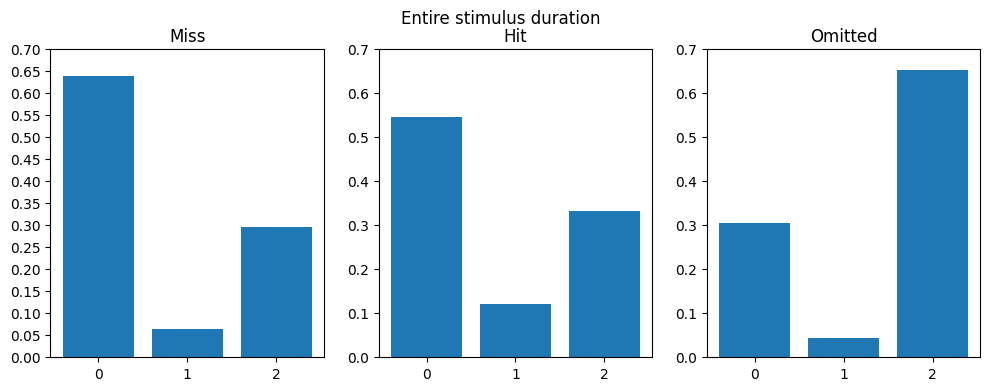

In [223]:
m_t = master_time[1250:-1250]
distribution=np.zeros((3, 3))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values

    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(3), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.71,0.05))
axs[1].bar(np.arange(3), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.71,0.1));
axs[2].bar(np.arange(3), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.71,0.1));
fig.suptitle("Entire stimulus duration")

3it [00:34, 11.48s/it]


Text(0.5, 0.98, 'First half of the stimulus')

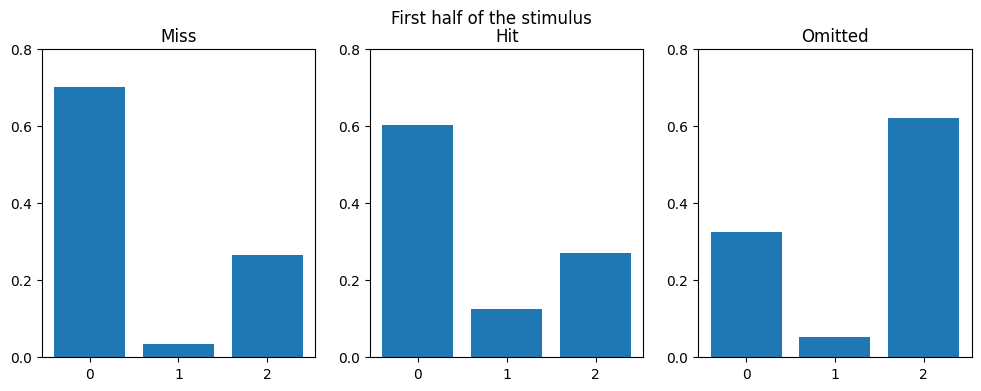

In [224]:
m_t = master_time[1250:-1250]
distribution=np.zeros((3, 3))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values

    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    stim_mid_idx = find_nearest_idx(m_t, (stim_start+stim_end)/2)
    
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:int(stim_mid_idx[i])], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(3), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.81,0.2))
axs[1].bar(np.arange(3), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.81,0.2));
axs[2].bar(np.arange(3), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.81,0.2));
fig.suptitle('First half of the stimulus')

3it [00:34, 11.51s/it]


Text(0.5, 0.98, 'Second half of the stimulus')

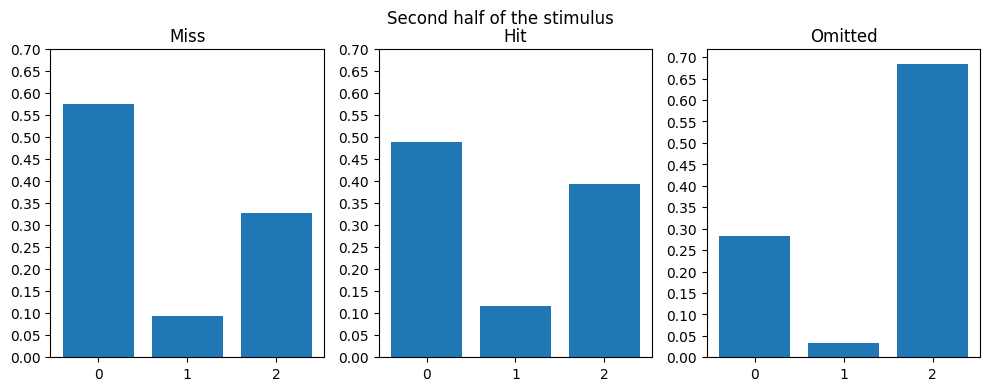

In [225]:
m_t = master_time[1250:-1250]
distribution=np.zeros((3, 3))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values

    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    stim_mid_idx = find_nearest_idx(m_t, (stim_start+stim_end)/2)
    
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[int(stim_mid_idx[i]):stim_end_idx[i]], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(3), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.71,0.05))
axs[1].bar(np.arange(3), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.71,0.05));
axs[2].bar(np.arange(3), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.71,0.05));
fig.suptitle('Second half of the stimulus')

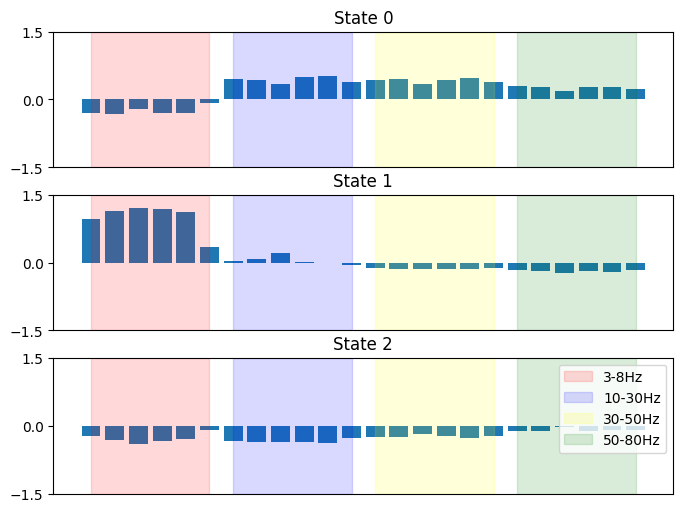

In [228]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].bar(np.arange(len(model.means_[i])),model.means_[i])
    axs[i].set_yticks(np.linspace(-1.5,1.5,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

0 1250


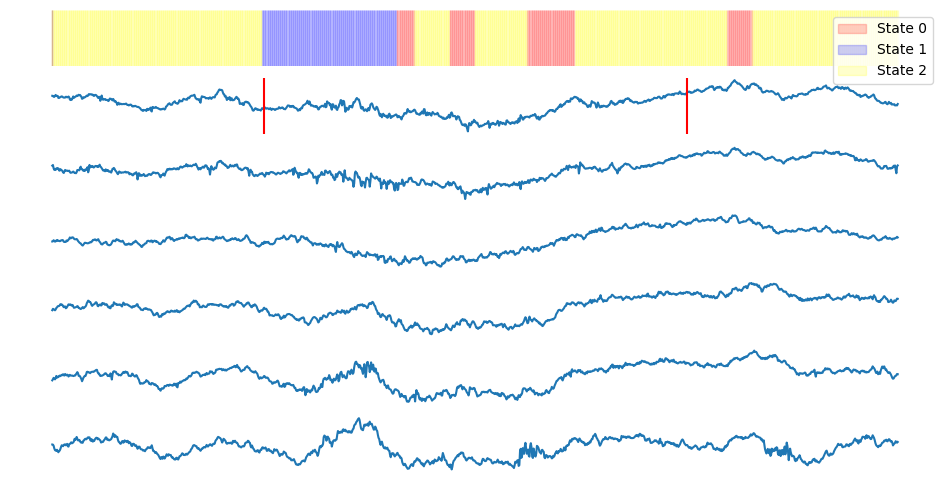

In [229]:
fig,axs=plt.subplots(7,1,figsize=(12,6))
# find a stimulus that contain all four states
for idx, i in enumerate(sp.index):
    s = sp.loc[i]
    s_start_idx = find_nearest_idx(m_t, [s.start_time-0.25])[0]
    s_end_idx = find_nearest_idx(m_t, [s.end_time+0.5])[0]
    print(s_start_idx, s_end_idx)
    unique, count = np.unique(preds[s_start_idx:s_end_idx], return_counts=True)
    if len(unique)==3:
        target = s
        break

# plot the lfp of the stimulus
start_t = target.start_time-0.25
start_i = find_nearest_idx(master_time, [start_t])[0]
end_t = target.end_time+0.5
end_i = find_nearest_idx(master_time, [end_t])[0]
state = preds[start_i-1250:end_i-1250]

colors = ['red', 'blue', 'yellow']
current_time = 0
for idx, i in enumerate(state):
    axs[0].axvspan(idx, idx, alpha=0.2, color=colors[i])


axs[1].plot(lfp[0][start_i:end_i])
axs[1].axvline(250/0.8, color='red')
axs[1].axvline(750/0.8, color='red')
axs[2].plot(lfp[1][start_i:end_i])
axs[3].plot(lfp[2][start_i:end_i])
axs[4].plot(lfp[3][start_i:end_i])
axs[5].plot(lfp[4][start_i:end_i])
axs[6].plot(lfp[5][start_i:end_i])

for i in range(0,7):
    axs[i].axis('off')
axs[0].axvspan(0,0,alpha=0.2, color='red', label='State 0')
axs[0].axvspan(0,0,alpha=0.2, color='blue', label='State 1')
axs[0].axvspan(0,0,alpha=0.2, color='yellow', label='State 2')
#axs[0].axvspan(0,0,alpha=0.2, color='green', label='State 3')
axs[0].legend()

In [109]:
hit_012 = hit[hit['image_name']==imgs[0]]
hit_012_prev = sp.loc[hit_012.index-1]
hit_036_012 = sp.loc[hit_012_prev[hit_012_prev.image_name=='im036_r'].index+1]

In [116]:
miss_036 = miss[miss['image_name']==imgs[3]]
miss_036_prev = sp.loc[miss_036.index-1]
display(miss_036_prev)
miss_111_036 = sp.loc[miss_036_prev[miss_036_prev.image_name=='im111_r'].index+1]

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,position_x,stimulus_name,color,contrast,rewarded,spatial_frequency,active,position_y,orientation,temporal_frequency
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
952,0,im083_r,0.250197,742.256812,742.507008,42902,42917,False,False,False,...,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,NaN,False,NaN,True,NaN,NaN,NaN
2104,0,im044_r,0.250219,1607.066877,1607.317096,94744,94759,False,False,False,...,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,NaN,False,NaN,True,NaN,NaN,NaN
3475,0,im044_r,0.250227,2636.248513,2636.498740,156443,156458,False,False,False,...,NaN,Natural_Images_Lum_Matched_set_ophys_G_2019,NaN,NaN,False,NaN,True,NaN,NaN,NaN


3it [00:05,  2.00s/it]


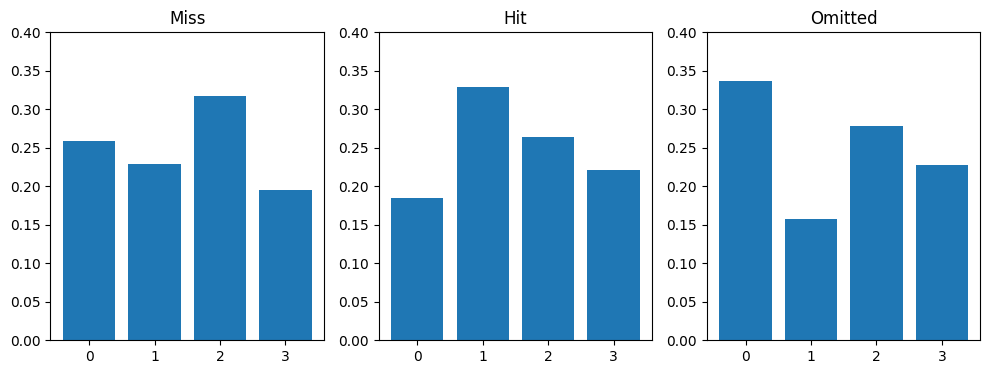

In [99]:
m_t = master_time[250:-250]
distribution=np.zeros((3, 4))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values

    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    stim_mid_idx = (stim_start_idx+stim_end_idx)//2
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:int(stim_mid_idx[i])], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(4), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.41,0.05))
axs[1].bar(np.arange(4), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.41,0.05));
axs[2].bar(np.arange(4), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.41,0.05));

In [39]:
def plot_means(model, Wns):
    n_state = len(model.means_)
    n_sample = len(model.means_[0])
    fig, axs=plt.subplots(n_state, 1, figsize=(8,8))
    colors = ['r','b','y','g','c','m']
    for i in range(n_state):
        axs[i].bar(np.arange(n_sample), model.means_[i])
        axs[i].set_yticks(np.linspace(-2,2,3))
        start_j = 0
        end_j = 5
        for j in range(len(Wns)):
            axs[i].axvspan(start_j, end_j, alpha=0.15, color=colors[j], label=f'{Wns[j][0]}-{Wns[j][1]}Hz')
            start_j += 6
            end_j += 6
        axs[i].set_title(f'State {i}')
    fig.legend()

In [29]:
def plot_dist(master_time, stim, preds, num, ylim):
    y_inc = ylim/5
    ylim = y_inc*5+0.01
    m_t = master_time[100:]
    all_stims = np.unique(stim['image_name'].values)
    u_mask = np.ones(len(m_t), dtype=int)
    distribution=np.zeros((10,num))
    for s_idx, s in tqdm(enumerate(all_stims)):
        stim_start = stim[stim['image_name'] == s].start_time.values
        stim_end = stim[stim['image_name'] == s].end_time.values
        stim_start_idx = find_nearest_idx(m_t, stim_start)
        stim_end_idx = find_nearest_idx(m_t, stim_end)
        for i, idx in enumerate(stim_start_idx):
            unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
            u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
            for j, u in enumerate(unique):
                distribution[s_idx][u] += counts[j]
    u_preds=preds[u_mask==1]
    unique, counts = np.unique(u_preds, return_counts=True)

    for i, u in enumerate(unique):
        distribution[-1][u] += counts[i]
    d = deepcopy(distribution)
    for i in range(10):
        d[i] = d[i]/np.sum(d[i])
    fig, axs = plt.subplots(3, 4,figsize=(15,12))
    for i in range(3):
        for j in range(4):
            try:
                axs[i][j].bar(np.arange(num), d[i*4+j])
            except:
                axs[i][j].axis('off')
                continue
            try:
                axs[i][j].set_title(all_stims[i*4+j])
            except:
                axs[i][j].set_title('gray')
            
            axs[i][j].set_yticks(np.arange(0,ylim,y_inc))

9it [01:06,  7.37s/it]


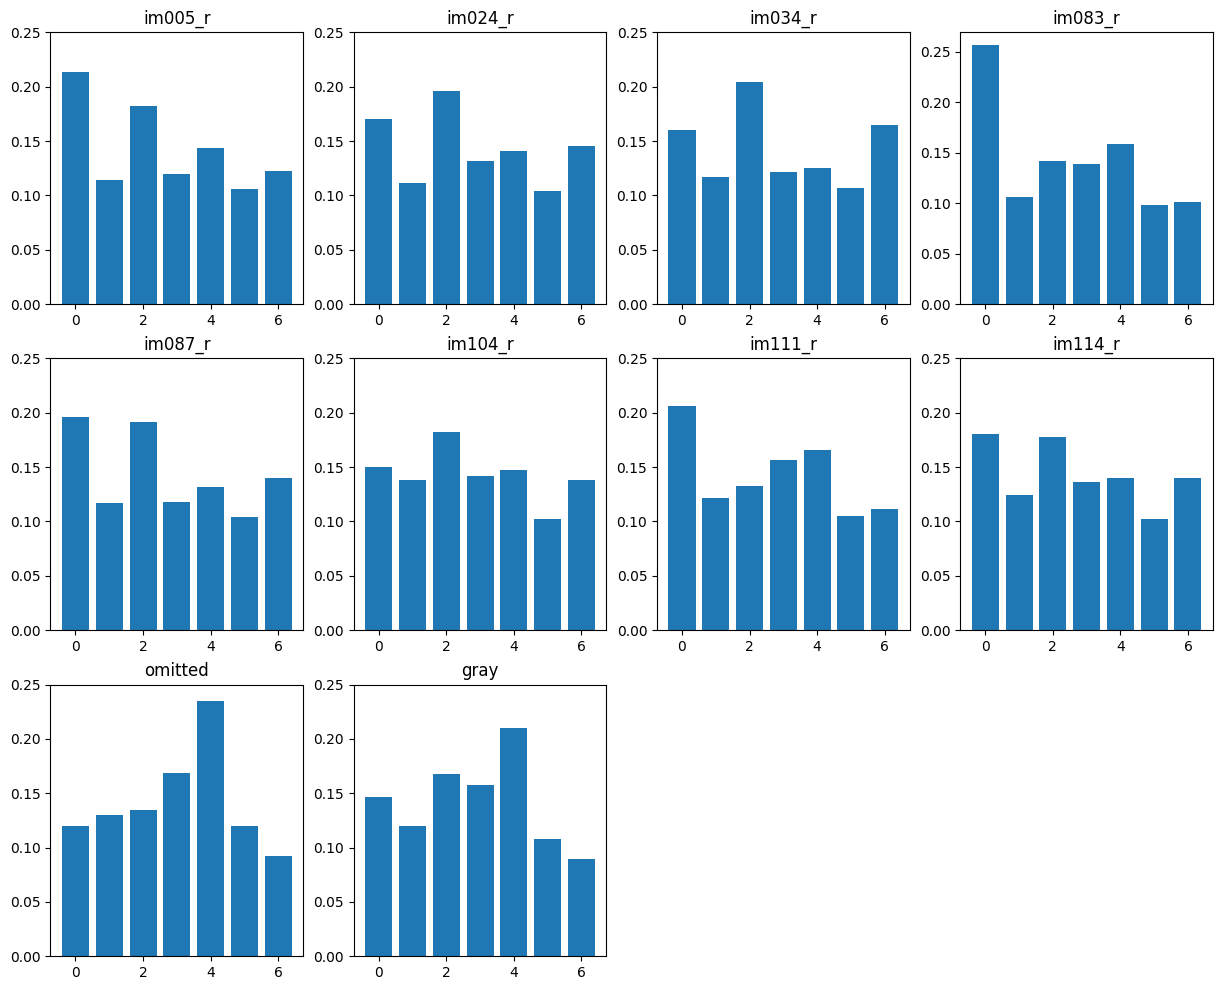

In [417]:
plot_dist(master_time, stim, preds, 7)

#### 7 hidden states

In [139]:
model = hmm.GaussianHMM(n_components=7, n_iter=1000, verbose=True, tol=0.1)
model.fit(b_z.T)
preds = model.predict(b_z.T)

         1 -30438433.40545312             +nan
         2 -27626771.72397177 +2811661.68148135
         3 -26256345.62671513 +1370426.09725663
         4 -25853600.20248668 +402745.42422845
         5 -25788590.08579929  +65010.11668739
         6 -25766485.96005420  +22104.12574508
         7 -25755268.81146418  +11217.14859002
         8 -25747789.18224397   +7479.62922021
         9 -25742147.11638859   +5642.06585538
        10 -25737934.31661169   +4212.79977690
        11 -25734833.92534499   +3100.39126670
        12 -25732578.73046005   +2255.19488494
        13 -25730866.79579204   +1711.93466800
        14 -25729550.39937799   +1316.39641405
        15 -25728529.88810449   +1020.51127350
        16 -25727758.31958620    +771.56851828
        17 -25727157.05985219    +601.25973402
        18 -25726666.09933399    +490.96051819
        19 -25726258.75030476    +407.34902924
        20 -25725904.07795963    +354.67234512
        21 -25725593.48863264    +310.58932700
        22 

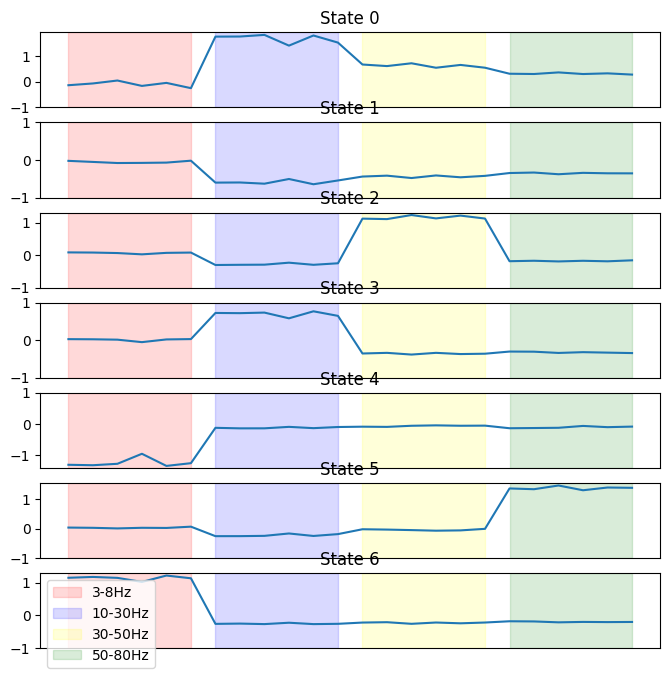

In [141]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,8))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

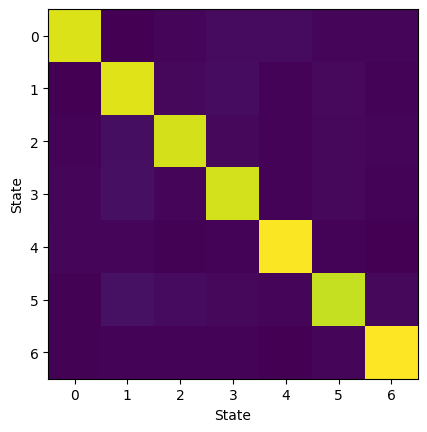

In [143]:
plt.imshow(model.transmat_)
plt.xlabel('State')
plt.ylabel('State');

3it [00:06,  2.27s/it]


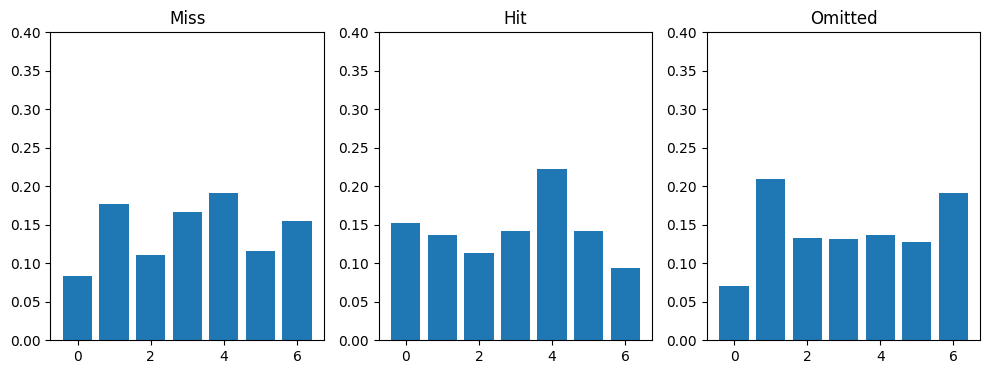

In [147]:
m_t = master_time[250:-250]
distribution=np.zeros((3, 7))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(7), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.41,0.05))
axs[1].bar(np.arange(7), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.41,0.05));
axs[2].bar(np.arange(7), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.41,0.05));

Text(0, 0.5, 'difference %')

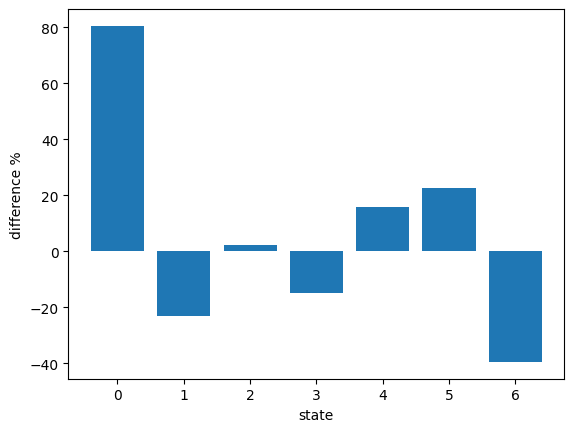

In [157]:
diff=(d[1]-d[0])/d[0]
plt.bar(np.arange(7), diff*100)
plt.xlabel('state')
plt.ylabel('difference %')

<BarContainer object of 63 artists>

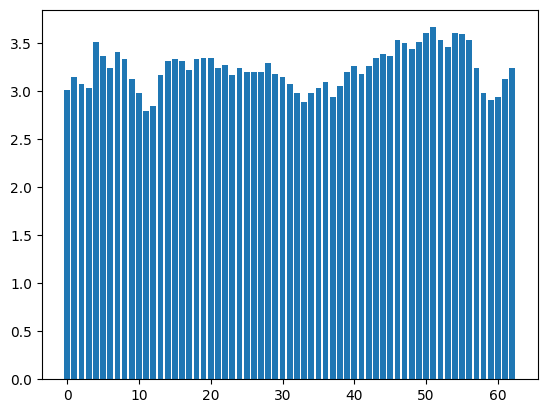

In [162]:
total = np.zeros(63)
counter = 0
for i in range(len(miss)):
    arr = preds[find_nearest_idx(m_t, [miss.start_time.values[i]])[0]:find_nearest_idx(m_t, [miss.end_time.values[i]])[0]]
    if len(arr) != 63:
        continue
    counter += 1
    total += arr
total = total/counter
plt.bar(np.arange(63), total)

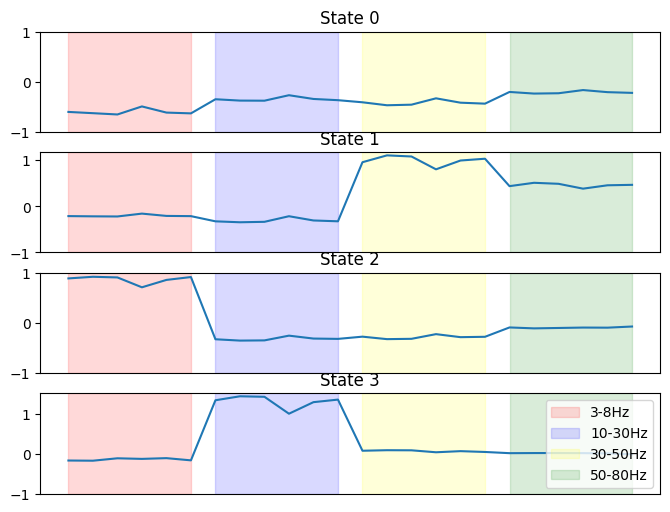

In [123]:
fig, axs=plt.subplots(len(model1.means_),1,figsize=(8,6))
for i in range(len(model1.means_)):
    axs[i].plot(model1.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

In [96]:
mask = np.arange(0,96,6)
all_channels = lfpC_copy[:,mask].T

In [97]:
all_channels.shape

(16, 900941)

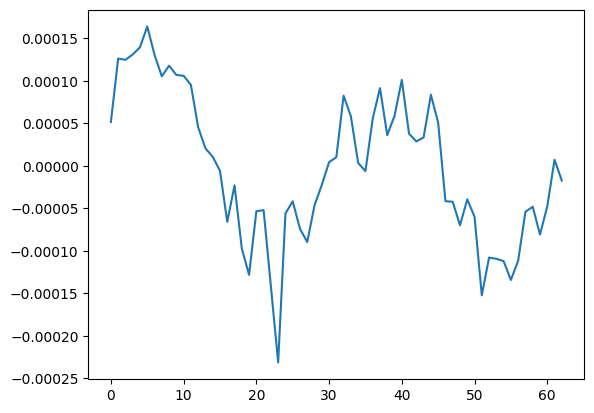

In [163]:
a = A_chan[:,0]
plt.plot(a[find_nearest_idx(master_time, [miss.start_time.values[0]])[0]:find_nearest_idx(master_time, [miss.end_time.values[0]])[0]])

In [177]:
500/0.8

625.0

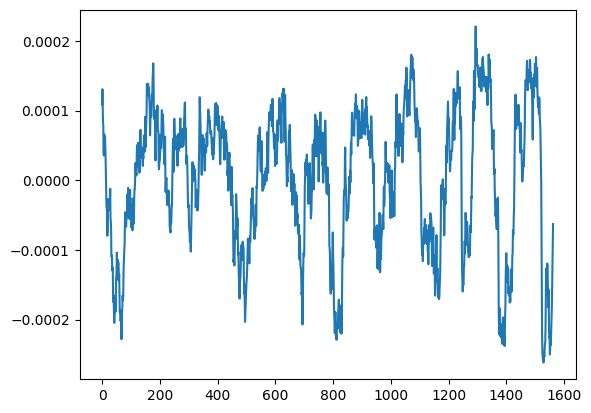

In [178]:
a = A_chan[:,0]
a_sec = a[find_nearest_idx(master_time, [hit.start_time.values[0]-0.5])[0]:find_nearest_idx(master_time, [hit.end_time.values[0]+0.5])[0]]
plt.plot(a_sec)

In [184]:
f,t,sxx = spectrogram(a_sec, fs=1250, nperseg=25)

In [185]:
f.shape, sxx.shape

((13,), (13, 70))

In [186]:
f

array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
       550., 600.])

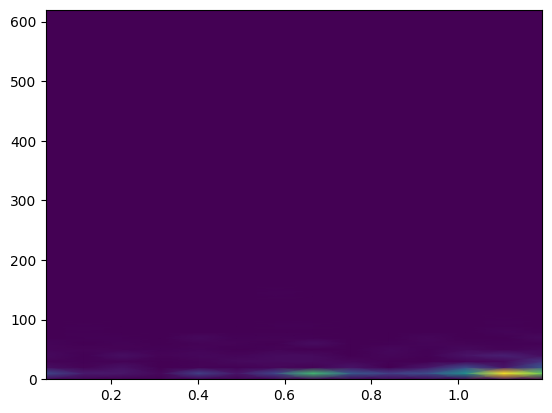

In [181]:
plt.pcolormesh(t, f, sxx, shading='gouraud')

In [98]:
bands = np.zeros((4, 16, len(C_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
bands = np.reshape(bands,(4*16, len(A_chan)))
bands = bands[:,100:].T
bands_z_0 = zscore(bands, axis=0)
print(bands.shape)
print(bands_z_0.shape)

(900841, 64)
(900841, 64)


In [99]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=0.1)
model.fit(bands_z_0)
preds = model.predict(bands_z_0)

         1 -79654927.74559742             +nan
         2 -75007807.47834232 +4647120.26725510
         3 -74223612.75211824 +784194.72622408
         4 -74147337.72272930  +76275.02938895
         5 -74121001.43709689  +26336.28563240
         6 -74106131.96378104  +14869.47331585
         7 -74095817.95151670  +10314.01226434
         8 -74088111.52348438   +7706.42803232
         9 -74082195.72579899   +5915.79768538
        10 -74077632.25421530   +4563.47158369
        11 -74074027.68527034   +3604.56894496
        12 -74071032.85081024   +2994.83446009
        13 -74068463.05794869   +2569.79286155
        14 -74066236.02721395   +2227.03073475
        15 -74064191.07145339   +2044.95576055
        16 -74062255.43977113   +1935.63168226
        17 -74060486.00111635   +1769.43865478
        18 -74058889.16731597   +1596.83380038
        19 -74057409.93411426   +1479.23320171
        20 -74056047.32094660   +1362.61316766
        21 -74054785.12680927   +1262.19413733
        22 -

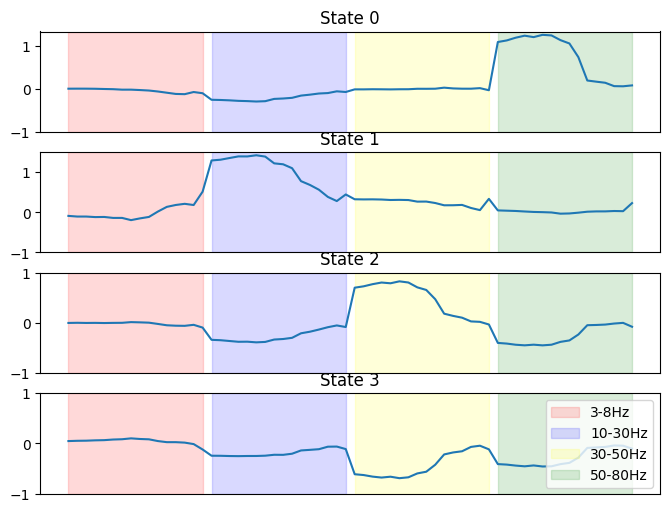

In [100]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 15, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(16, 31, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(32, 47, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(48, 63, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

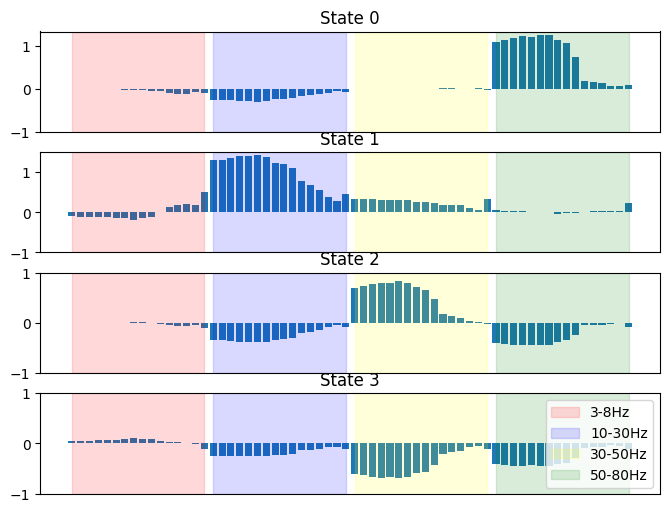

In [303]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].bar(np.arange(64), model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 15, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(16, 31, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(32, 47, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(48, 63, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

#### Power Spectrum

In [12]:
bands = np.zeros((4, 6, len(A_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.vstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env) # type: ignore
    bands[i] = all_channels_env_abs
print(bands.shape)
bands = bands[:,:,250:-250]
print(bands.shape)

(4, 6, 901341)
(4, 6, 900841)


In [14]:
master_time.shape

(901341,)

In [15]:
m_t = master_time[250:-250]

In [45]:
all_env = deepcopy(bands)
hit_starts = find_nearest_idx(m_t, hit.start_time.values-0.250)
hit_ends = find_nearest_idx(m_t, hit.end_time.values+0.5)
miss_starts = find_nearest_idx(m_t, miss.start_time.values-0.250)
miss_ends = find_nearest_idx(m_t, miss.end_time.values+0.5) 
omit_starts = find_nearest_idx(m_t, omitted.start_time.values-0.250)
omit_ends = find_nearest_idx(m_t, omitted.end_time.values+0.5)

In [44]:
# differentiating hit and miss trials
hit_env = np.zeros((4, 250))
miss_env = np.zeros((4, 250))
omit_env = np.zeros((4, 250))
hit_err = 0
miss_err = 0
omit_err = 0
for i in range(4):
    env = all_env[i]
    for j in range(len(hit_starts)):
        avg = np.mean(env[:,hit_starts[j]:hit_ends[j]],axis=0)
        if len(avg) < 250:
            if len(avg) < 250*0.95:
                hit_err+=1
                continue
            else:
                avg = np.append(avg, avg[-1]*(int(250-len(avg))))
        if len(avg) > 250:
            avg = avg[:250]
        hit_env[i] += avg
    for j in range(len(miss_starts)):
        avg = np.mean(env[:,miss_starts[j]:miss_ends[j]],axis=0)
        if len(avg) < 250:
            if len(avg) < 250*0.95:
                miss_err+=1
                continue
            else:
                avg = np.append(avg, avg[-1]*(int(250-len(avg))))
        if len(avg) > 250:
            avg = avg[:250]
        miss_env[i] += avg
    for j in range(len(omit_starts)):
        avg = np.mean(env[:,omit_starts[j]:omit_ends[j]],axis=0)
        if len(avg) < 250:
            if len(avg) < 250*0.95:
                omit_err+=1
                continue
            else:
                avg = np.append(avg, avg[-1]*(int(250-len(avg))))
        if len(avg) > 250:
            avg = avg[:250]
        omit_env[i] += avg

In [48]:
# differentiating hit and miss trials
hit_err = 0
miss_err = 0
omit_err = 0
hit_all = np.zeros((4, len(hit_starts), 6, 250))
miss_all = np.zeros((4, len(miss_starts), 6, 250))
omit_all = np.zeros((4, len(omit_starts), 6, 250))
for i in range(4):
    env = all_env[i]
    for j in range(len(hit_starts)):
        avg = env[:,hit_starts[j]:hit_ends[j]]
        if avg.shape[1] > 250:
            avg = avg[:, :250]
        hit_all[i][j] = avg
    for j in range(len(miss_starts)):
        avg = env[:,miss_starts[j]:miss_ends[j]]
        if avg.shape[1] > 250:
            avg = avg[:, :250]
        miss_all[i][j] = avg
    for j in range(len(omit_starts)):
        avg = env[:,omit_starts[j]:omit_ends[j]]
        if avg.shape[1] < 250:
            if avg.shape[1] < 250*0.95:
                omit_err+=1
                continue
        if avg.shape[1] > 250:
            avg = avg[:, :250]
        omit_all[i][j] = avg

In [56]:
hs = np.reshape(hit_all, (4, len(hit_starts)*6, 250))
ms = np.reshape(miss_all, (4, len(miss_starts)*6, 250))
os = np.reshape(omit_all, (4, len(omit_starts)*6, 250))

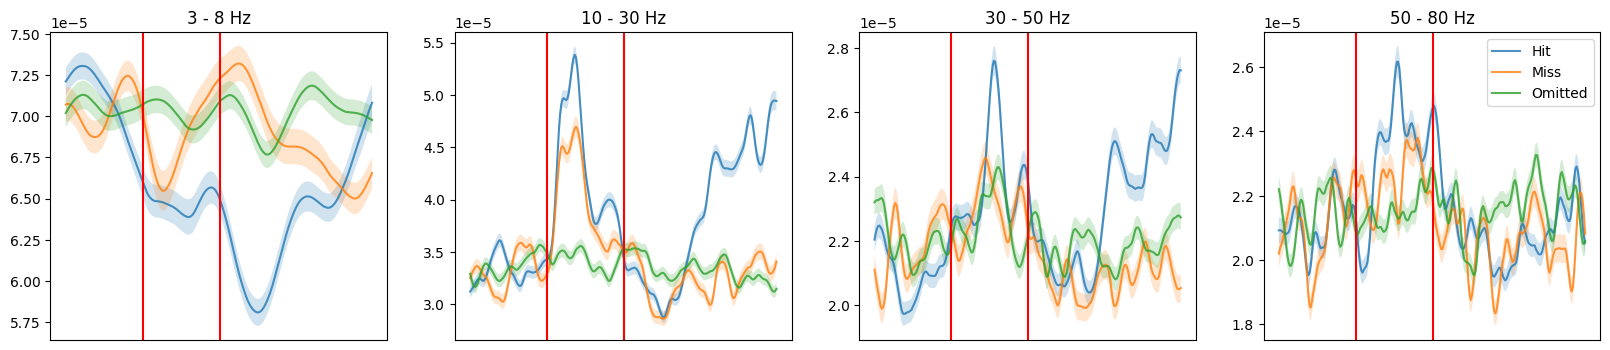

In [86]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, ax in enumerate(axs):
    h = hs[i]
    m = ms[i]
    o = os[i]
    ax.plot(np.mean(h, axis=0), alpha=0.8, label='Hit')
    ax.fill_between(np.arange(250), np.mean(h, axis=0)-sem(h, axis=0), np.mean(h, axis=0)+sem(h, axis=0), alpha=0.2)
    ax.plot(np.mean(m, axis=0), alpha=0.8, label='Miss')
    ax.fill_between(np.arange(250), np.mean(m, axis=0)-sem(m, axis=0), np.mean(m, axis=0)+sem(m, axis=0), alpha=0.2)
    ax.plot(np.mean(o, axis=0), alpha=0.8, label='Omitted')
    ax.fill_between(np.arange(250), np.mean(o, axis=0)-sem(o, axis=0), np.mean(o, axis=0)+sem(o, axis=0), alpha=0.2)
    ax.axvline(250/4, color='r')
    ax.axvline(500/4, color='r')
    ax.xaxis.set_ticks([])
    ax.set_title(f'{Wns[i][0]} - {Wns[i][1]} Hz')
plt.legend();

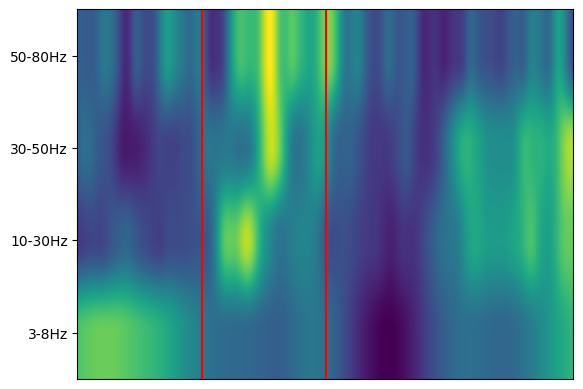

In [235]:
temp=np.array([zscore(np.mean(hs[3], axis=0)),zscore(np.mean(hs[2], axis=0)), zscore(np.mean(hs[1], axis=0)), zscore(np.mean(hs[0], axis=0)),])
plt.imshow(temp, aspect='auto')
plt.axvline(250/4, color='r')
plt.axvline(500/4, color='r')
plt.xticks([]);
plt.yticks([0,1,2,3],['50-80Hz','30-50Hz','10-30Hz','3-8Hz']);

In [245]:
n_f = 100
duration = 250
n_probe = 6

In [246]:
real = np.zeros((n_f, 6, len(A_chan)))
imag = np.zeros((n_f, 6, len(A_chan)))
powers = np.zeros((n_f, 6, len(A_chan)))
Wns = np.arange(1,102,1)
all_channels = np.vstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
for i in tqdm(range(len(Wns)-1)):
    sos = butter(N=3, Wn=[Wns[i], Wns[i+1]], fs=250, btype='bandpass', output='sos')
    all_channels_ff = sosfiltfilt(sos, all_channels)
    all_channels_env = hilbert(all_channels_ff)
    real[i] = np.real(all_channels_env) # type: ignore
    imag[i] = np.imag(all_channels_env) # type: ignore
    powers[i] = real[i]**2 + imag[i]**2
print(powers.shape) # 100 bands, 6 channels(1 channel/probe), 900k samples

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: The length of the input vector x must be greater than padlen, which is 21.

In [231]:
ps = powers[:,:,250:-250]
ps.shape

(10, 6, 900841)

In [232]:

hit_p = np.zeros((n_f, len(hit_starts), n_probe, duration))
miss_p = np.zeros((n_f, len(miss_starts), n_probe, duration))
omit_p = np.zeros((n_f, len(omit_starts), n_probe, duration))
for i in range(n_f):
    p = ps[i]
    for j in range(len(hit_starts)):
        avg = p[:,hit_starts[j]:hit_ends[j]]
        if avg.shape[1] > duration:
            avg = avg[:, :duration]
        hit_p[i][j] = zscore(avg, axis=1)
    for j in range(len(miss_starts)):
        avg = p[:,miss_starts[j]:miss_ends[j]]
        if avg.shape[1] > duration:
            avg = avg[:, :duration]
        miss_p[i][j] = zscore(avg, axis=1)
    for j in range(len(omit_starts)):
        avg = p[:,omit_starts[j]:omit_ends[j]]
        if avg.shape[1] < duration:
            if avg.shape[1] < duration*0.95:
                continue
        if avg.shape[1] > duration:
            avg = avg[:, :duration]
        omit_p[i][j] = zscore(avg, axis=1)

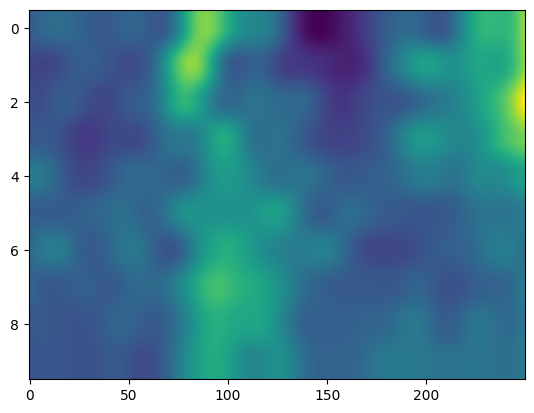

In [233]:
h_p = np.reshape(hit_p, (n_f, len(hit_starts) * n_probe, duration))
h_p_avg = np.mean(h_p, axis=1)
plt.imshow(h_p_avg, aspect='auto')

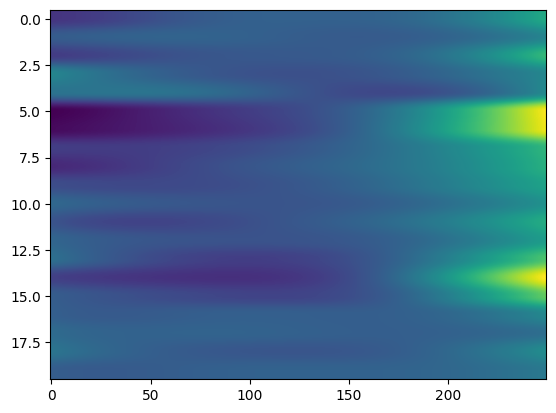

In [216]:
plt.imshow(h_p_avg[10:30], aspect='auto')




In [197]:
f1 = h_p_avg[1]
np.sum(f1)

0.0

In [259]:
# differentiating hit and miss trials
hit_env = np.zeros(100)
miss_env = np.zeros(100)
omit_env = np.zeros(100)
all_env = deepcopy(bands)
hit_starts = find_nearest_idx(m_t, hit.start_time.values)
hit_ends = find_nearest_idx(m_t, hit.end_time.values)
miss_starts = find_nearest_idx(m_t, miss.start_time.values)
miss_ends = find_nearest_idx(m_t, miss.end_time.values)
omit_starts = find_nearest_idx(m_t, omitted.start_time.values)
omit_ends = find_nearest_idx(m_t, omitted.end_time.values)
for i in tqdm(range(100)):
    env = all_env[i]
    for j in range(len(hit_starts)):
        hit_env[i] += np.sum(env[:,hit_starts[j]:hit_ends[j]])
    for j in range(len(miss_starts)):
        miss_env[i] += np.sum(env[:,miss_starts[j]:miss_ends[j]])
    for j in range(len(omit_starts)):
        omit_env[i] += np.sum(env[:,omit_starts[j]:omit_ends[j]])

100%|██████████| 100/100 [00:00<00:00, 313.62it/s]


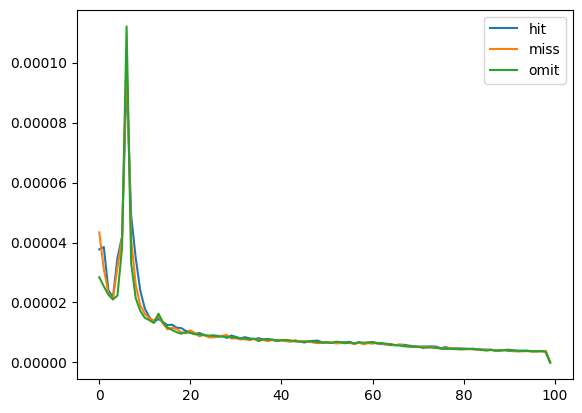

In [293]:
plt.plot(np.arange(100), hit_env/hit_count, label='hit')
plt.plot(np.arange(100), miss_env/miss_count, label='miss')
plt.plot(np.arange(100), omit_env/omit_count, label='omit')
#plt.xticks(ticks=np.arange(4), labels=['3-8Hz','10-30Hz','30-50Hz','50-80Hz'])
plt.legend()

In [287]:
powers = np.zeros((100, 6, len(A_chan)))
real = np.zeros((100, 6, len(A_chan)))
imag = np.zeros((100, 6, len(A_chan)))
Wns = np.arange(1,101,1)
for i in tqdm(range(len(Wns)-1)): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=[Wns[i], Wns[i+1]], fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, A_chan) 
    all_channels_env = hilbert(all_channels_ff)
    real[i] = np.real(all_channels_env)
    imag[i] = np.imag(all_channels_env)
    powers[i] = real[i]**2 + imag[i]**2

100%|██████████| 99/99 [00:35<00:00,  2.77it/s]


In [299]:
imag[0].mean(axis=1)

array([1.92460287e-24, 1.92460287e-24, 1.92460287e-24, 1.92460287e-24,
       1.92460287e-24, 1.92460287e-24])

In [298]:
imag[0].mean(axis=0).mean()

-5.773808611757838e-24

In [285]:
# differentiating hit and miss trials
hit_env2 = np.zeros(100)
miss_env2 = np.zeros(100)
omit_env2 = np.zeros(100)
print(powers.shape)
all_env2 = deepcopy(powers)[:,:,250:-250]
print(all_env2.shape)
for i in range(100):
    env = all_env2[i]
    for j in range(len(hit_starts)):
        hit_env2[i] += np.sum(env[:,hit_starts[j]:hit_ends[j]])
    for j in range(len(miss_starts)):
        miss_env2[i] += np.sum(env[:,miss_starts[j]:miss_ends[j]])
    for j in range(len(omit_starts)):
        omit_env2[i] += np.sum(env[:,omit_starts[j]:omit_ends[j]])

(100, 6, 901341)
(100, 6, 900841)


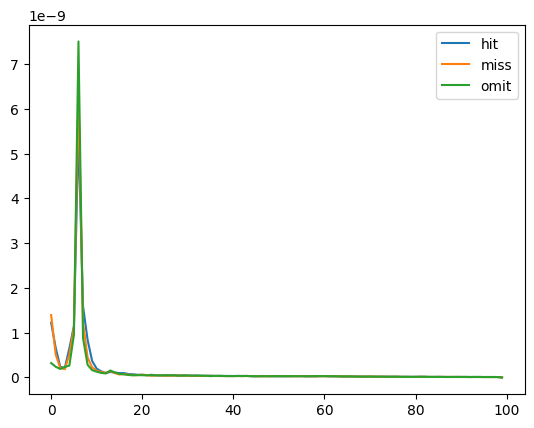

In [286]:
plt.plot(np.arange(100), hit_env2/hit_count, label='hit')
plt.plot(np.arange(100), miss_env2/miss_count, label='miss')
plt.plot(np.arange(100), omit_env2/omit_count, label='omit')
#plt.xticks(ticks=np.arange(4), labels=['3-8Hz','10-30Hz','30-50Hz','50-80Hz'])
plt.legend()

In [183]:
f,t,zxx = stft(A_chan, fs=250, nperseg=1)

In [184]:
np.sum(np.imag(zxx[0]))

0.0

In [129]:
sos = butter(N=3, Wn=[1,2], fs=250, btype='bandpass', output='sos')
all_channels_ff = sosfiltfilt(sos, A_chan)[250:-250]

In [141]:
a_stft = stft(all_channels_ff, fs=250)

In [145]:
len(a_stft)

3

In [146]:
f = a_stft[0]
t = a_stft[1]
zxx = a_stft[2]

In [161]:
from scipy.signal import spectrogram

In [168]:
B_chan

<xarray.DataArray 'LFP' (time: 901341)>
array([ 8.11200e-05,  1.45080e-04,  1.11150e-04, ..., -1.45860e-04,
       -6.31800e-05, -1.11735e-04], dtype=float32)
Coordinates:
  * time     (time) float64 24.24 24.25 24.25 ... 3.63e+03 3.63e+03 3.63e+03
    channel  int64 1145244967

In [171]:
f,t,sxx = spectrogram(np.vstack(A_chan.values), fs=250)

##### Spectrogram

In [120]:
hit_start_2 = find_nearest_idx(master_time, [hit.iloc[2].start_time])[0]
hit_end_2 = find_nearest_idx(master_time, [hit.iloc[2].end_time])[0]
a_chan_sec = A_chan[hit_start_2:hit_end_2,0]

In [121]:
a_chan_sec.shape

(62,)

In [133]:
f,t,sxx = spectrogram(a_chan_sec, fs=250, nperseg=30)

In [17]:
start = sp.start_time.values
end = sp.end_time.values
master_time = np.arange(start[0], end[-1], 1/1250)
start_idx = nearest_arr(master_time, start)
end_idx = nearest_arr(master_time, end)

In [18]:
# doing this on probeA first
probeA = session.get_lfp(1062886496)

In [118]:
chan = session.get_channels()
chans = chan.loc[probeB.channel]
VIS_chans = chans[chans['structure_acronym']=='VISpm']
print(len(VIS_chans))

22


In [119]:
lfps = np.zeros((len(VIS_chans), len(master_time)))
for idx, chn in enumerate(VIS_chans.index.values):
    chan = probeB.sel(channel=chn)
    chan_slice = chan.sel(time=master_time, method='nearest')
    lfps[idx] = chan_slice.values

In [120]:
lfps_mean = np.zeros((len(VIS_chans), 1800))
for idx, l in tqdm(enumerate(lfps)):
    lfps_seg = np.zeros((2200, 1800))
    for i in range(2200):
        lfps_seg[i] = lfps[idx][start_idx[i]:end_idx[i+1]+625][:1800]
    lfps_mean[idx] = np.mean(lfps_seg, axis=0)

22it [00:00, 67.63it/s]


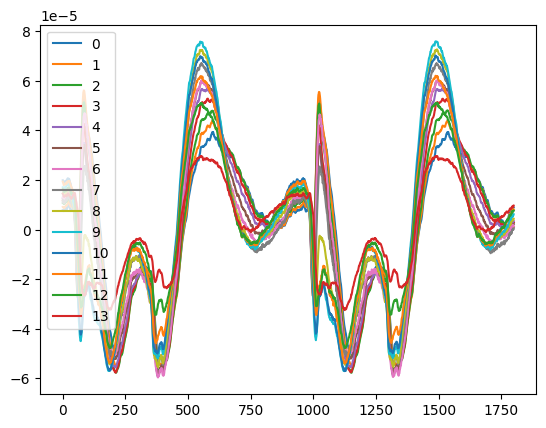

In [116]:
for i in range(len(VIS_chans)-4):
    plt.plot(lfps_mean[i], label=f'{i}')
plt.legend()

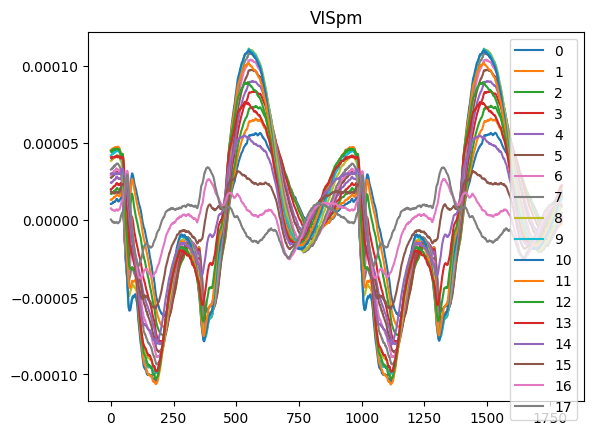

In [121]:
for i in range(len(VIS_chans)-4):
    plt.plot(lfps_mean[i], label=f'{i}')
plt.title('VISpm')
plt.legend()
